In [65]:
from ews.models import BathingSpot
from django_pandas.io import read_frame
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from shapely.geometry import shape, Point
import plotly.express as px
import statsmodels


In [2]:
model = PredictionModel.objects.get(name = "ML model1")

In [3]:
PredictionModel.objects.all()

<QuerySet [<PredictionModel: First model>, <PredictionModel: Second model>, <PredictionModel: testmodel>, <PredictionModel: ML model1>]>

In [4]:
areas = read_frame(model.area.all())

In [5]:
areavars = []
for index1, row1 in areas.iterrows():
    df = read_frame(Site.objects.filter(feature_type = FeatureType.objects.get(name=row1["feature_type"])))
    polygon = shape(row1["geom"])
    select = []
    
    for index2, row2 in df.iterrows():
        select.append(polygon.contains(shape(row2['geom'])))
    data = read_frame(FeatureData.objects.filter(site__in = df[select]['id']), index_col = "date")
    data["area"] = row1["name"]
    data["feature_type"] = row1["feature_type"]
    areavars.append(data)

In [6]:
lagvars = []

for i in range(len(areavars)):
    ft = areavars[i].area.unique()
    d = areavars[i].pivot(columns = 'site', values = 'value')
    if len(d.columns) > 1:
        d = pd.DataFrame(d.mean(axis = 1, skipna = True))
    for j in [1, 2, 3, 4, 5]:
        df = pd.DataFrame()
        df[ft + '_shift_'+ str(j)] = d.rolling(window=j).mean().shift(1)
        lagvars.append(df)
        
res = pd.concat(lagvars, axis = 1)

<AxesSubplot:xlabel='date'>

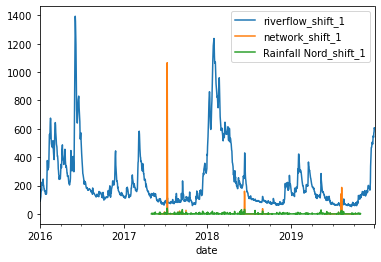

In [7]:
res.filter(regex='_shift_1').plot()

In [25]:
res = res[res.index.month.isin([ 6, 7, 8, 9])].reset_index()

In [22]:
FIB = read_frame(FeatureData.objects.filter(site = model.site.all()[0]))

In [27]:

d = FIB.merge(res, on= "date")

In [92]:
D = d.dropna()

In [93]:
y = np.log10(D["value"])

In [94]:
X = D.drop(["date", "value", "id", "site"], axis = 1)

In [126]:
rf = RandomForestRegressor()
rf.fit(X, y)
y_pred= rf.predict(X)
MSE(y, y_pred)

0.024340735499121177

In [110]:
df = pd.DataFrame({'meas': y, 'pred':y_pred})

In [147]:
fig = px.scatter(df, x = "meas", y = "pred", trendline="ols")

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Model fit of Random Forest model'},
    xaxis_title = "measured data (sample)",
    yaxis_title = "fitted values (in sample fit)",
    #markercolor = "#212c52"
  
)
fig.update_traces(marker_color='#75c3ff', marker_line_color='#212c52',
                  marker_line_width=1.5, opacity=1)

fig.show()

In [148]:
results = px.get_trendline_results(fig)
print(results)

#results.query("sex == 'Male' and smoker == 'Yes'").px_fit_results.iloc[0].summary()

                                      px_fit_results
0  <statsmodels.regression.linear_model.Regressio...


In [149]:
results.px_fit_results[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     835.5
Date:                Thu, 11 Feb 2021   Prob (F-statistic):           5.15e-32
Time:                        13:20:48   Log-Likelihood:                 47.248
No. Observations:                  50   AIC:                            -90.50
Df Residuals:                      48   BIC:                            -86.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6851      0.078      8.776      0.000       0.528       0.842
x1             0.7594      0.026     28.904      0.000       0.707       0.812
==============================================================================
Omnibus:                        5.562   Durbin-Watson:                   2.398
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                4.491
Skew:                           0.690   Prob(JB):                        0.106
Kurtosis:                       3.501   Cond. No.                         19.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [150]:
importances = pd.Series(data=rf.feature_importances_,
                        index= X.columns)

# Sort importances
importances_sorted = importances.sort_values()
importances_df = importances_sorted.reset_index()
importances_df.columns = ["feature", "importance"]

In [151]:
# Draw a horizontal barplot of importances_sorted
import plotly.express as px

fig = px.bar(importances_df, y="feature", x="importance", orientation='h'    )

fig.update_layout(
    font_family="Helvetica Neue, Helvetica, Arial, sans-serif",
    font_color="black",
    title = {'text':'Feature importance of Random Forest model'}
    #markercolor = "#212c52"
  
)
fig.update_traces(marker_color='#75c3ff', marker_line_color='#75c3ff',
                  marker_line_width=1.5, opacity=1)

fig.show()
